In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import requests
import json
from datetime import timedelta, datetime

api_key = '169c87ec-2424-4ddc-8c05-19942b7075aa'

# site id string preparation
plant_station_data = pd.read_csv('.\\Plant Station Location_20230820.csv')
site_list = plant_station_data['"siteid"'].to_list()
total_capacity = plant_station_data['capacity'].sum()



In [2]:

def fetch_data(site_id, start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    # num_sites = len(site_str.split(','))
    num_data = int((end_date - start_date).total_seconds() / 3600) 
    site_filter_str = f'siteid,EQ,{site_id}'
    time_filter_str = f'datacreationdate,GR,{start_date_str} 00:00:00|datacreationdate,LE,{end_date_str} 23:00:00'
    filter_str = f'{site_filter_str}|{time_filter_str}'
    fields_str = 'datacreationdate,site,sitename,aqi,so2_avg,pm2.5_avg,pm10_avg'
    url = f'https://data.epa.gov.tw/api/v2/aqx_p_488?format=json&offset=0&limit={num_data}&api_key={api_key}&filters={filter_str}&fields={fields_str}'
    response = requests.get(url)
    data = json.loads(response.content)
    return response, url, data

def get_record(data):
    record = pd.DataFrame(data['records'])
    record.drop('sitename', axis=1, inplace=True)
    record['datacreationdate'] = pd.to_datetime(record['datacreationdate'])
    record.set_index('datacreationdate', inplace=True)
    record['aqi'] = pd.to_numeric(record['aqi'], downcast='integer', errors='coerce')
    record['pm2.5_avg'] = pd.to_numeric(record['pm2.5_avg'], downcast='float', errors='coerce')
    record['pm10_avg'] = pd.to_numeric(record['pm10_avg'], downcast='float', errors='coerce')
    record['so2_avg'] = pd.to_numeric(record['so2_avg'], downcast='float', errors='coerce')
    return record

def get_all_data(site_id, start_date, end_date):
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")    
    # Max number of days for 1000 hourly data points
    MAX_DAYS = 41  # 1000 hours / 24 = 41.66 days    
    all_record_frames = []  # List to store dataframes from each fetch
    while start < end:
        # Calculate the next end date by adding MAX_DAYS, but ensure it doesn't exceed the user's end_date
        next_end = min(start + timedelta(days=MAX_DAYS), end)
        print(f'Getting data from {start.strftime("%Y-%m-%d")} to {next_end.strftime("%Y-%m-%d")}')
        # Fetch data for the current chunk
        _, _, data  = fetch_data(site_id, start.strftime("%Y-%m-%d"), next_end.strftime("%Y-%m-%d"))
        record = get_record(data)       
        all_record_frames.append(record)        
        # Move the start date for the next chunk
        start = next_end
    # Concatenate all the dataframes
    final_record = pd.concat(all_record_frames, axis=0)
    return final_record


In [25]:
plant_station_data.head()

,Unnamed: 0.1,Unnamed: 0,power_plant_name,power_plant_name_pinyin,power_plant_latitude,power_plant_longitude,station_name,station_name_pinyin,station_latitude,station_longitude,...,"""siteengname""","""areaname""","""county""","""township""","""siteaddress""","""twd97lon""","""twd97lat""","""sitetype""","""siteid""",capacity
0,0,0,和平電廠,Heping,24.306667,121.763889,冬山,Dongshan,24.632203,121.792928,...,Dongshan,宜蘭空品區,宜蘭縣,冬山鄉,宜蘭縣冬山鄉南興村照安路26號,121.792928,24.632203,一般站,66,1320.0
1,1,1,興達發電廠,Xingda,22.857222,120.196944,臺南,Tainan,22.991230,120.220850,...,Tainan,雲嘉南空品區,臺南市,東區,701台南市東區長榮路二段135號,120.220850,22.991230,一般站,46,4326.0
2,2,2,麥寮電廠,Mailiao,23.800000,120.183333,麥寮,Mailiao,23.753506,120.251825,...,Mailiao,雲嘉南空品區,雲林縣,麥寮鄉,雲林縣麥寮鄉中興路115號,120.251825,23.753506,工業站,83,4200.0
3,3,3,台中發電廠,Taizhong,24.212778,120.481111,沙鹿,Shalu,24.225628,120.568794,...,Shalu,中部空品區,臺中市,沙鹿區,臺中市沙鹿區英才路150號,120.568794,24.225628,一般站,29,5824.0
4,4,4,尖山發電廠,Jianshan,23.563056,119.661111,馬公,Magong,23.569031,119.566158,...,Magong,其他,澎湖縣,馬公市,澎湖縣馬公市中正路115號,119.566158,23.569031,一般站,78,140.0


In [31]:
# data acquisition

record_list = []

for i, s in enumerate(site_list):
    capacity = plant_station_data["capacity"][i]
    plant_name = plant_station_data["power_plant_name"][i]
    print(f'Getting data from {plant_name} (site_id: {s}, capacity: {capacity} MW)')
    record = get_all_data(s, '2019-08-01', '2023-08-02')
    record = record * capacity
    site_name_eng = plant_station_data['"siteengname"'][i]
    plant_name_eng = plant_station_data['power_plant_name_pinyin'][i]
    record_fn = f'{plant_name_eng}_{site_name_eng}'
    record.to_csv(f'.\\Data\\{record_fn}.csv')
    record_list.append(record)
    

Getting data from 和平電廠 (site_id: 66, capacity: 1320.0 MW)
Getting data from 2019-08-01 to 2019-09-11
Getting data from 2019-09-11 to 2019-10-22
Getting data from 2019-10-22 to 2019-12-02
Getting data from 2019-12-02 to 2020-01-12
Getting data from 2020-01-12 to 2020-02-22
Getting data from 2020-02-22 to 2020-04-03
Getting data from 2020-04-03 to 2020-05-14
Getting data from 2020-05-14 to 2020-06-24
Getting data from 2020-06-24 to 2020-08-04
Getting data from 2020-08-04 to 2020-09-14
Getting data from 2020-09-14 to 2020-10-25
Getting data from 2020-10-25 to 2020-12-05
Getting data from 2020-12-05 to 2021-01-15
Getting data from 2021-01-15 to 2021-02-25
Getting data from 2021-02-25 to 2021-04-07
Getting data from 2021-04-07 to 2021-05-18
Getting data from 2021-05-18 to 2021-06-28
Getting data from 2021-06-28 to 2021-08-08
Getting data from 2021-08-08 to 2021-09-18
Getting data from 2021-09-18 to 2021-10-29
Getting data from 2021-10-29 to 2021-12-09
Getting data from 2021-12-09 to 2022-01

In [10]:
record_list = []

for i, s in enumerate(site_list):      
    site_name_eng = plant_station_data['"siteengname"'][i]
    plant_name_eng = plant_station_data['power_plant_name_pinyin'][i]
    record_fn = f'{plant_name_eng}_{site_name_eng}'
    record = pd.read_csv(f'.\\Data\\{record_fn}.csv')
    record['datacreationdate'] = pd.to_datetime(record['datacreationdate'])
    record.set_index('datacreationdate', inplace=True)    
    record_list.append(record)



In [12]:
# remove duplicated entries & sort data
record_list_processed = []

for r in record_list:
    r_processed = r[~r.index.duplicated(keep='first')]
    r_processed = r_processed.sort_index()
    record_list_processed.append(r_processed)

    

In [13]:
# summation of all collected data and weighted by capacity

record_sum = record_list_processed[0].copy()

for i in range(len(record_list_processed[1:])):
    record_sum = record_sum.add(record_list_processed[i + 1], fill_value=0)

record_sum = record_sum / total_capacity
record_sum.head()

,aqi,pm2.5_avg,pm10_avg,so2_avg
datacreationdate,,,,
2019-08-01 11:00:00,34.618656,10.218021,23.492951,3.172256
2019-08-01 12:00:00,35.067159,9.977302,24.432298,3.172256
2019-08-01 13:00:00,35.039789,10.062029,24.805172,3.172256
2019-08-01 14:00:00,35.517640,10.016971,24.812734,2.979017
2019-08-01 15:00:00,36.324272,10.356997,25.057879,2.979017


<AxesSubplot: xlabel='datacreationdate'>

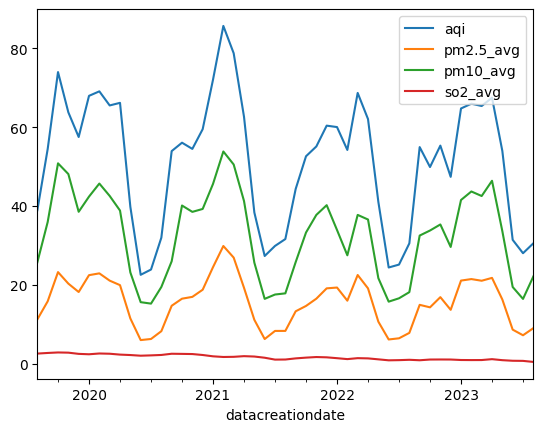

In [14]:
record_avg = record_sum.resample('M').mean()
record_avg.plot()

In [15]:
record_avg.to_csv('.\\plant_station_record_avg.csv')